In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            f1_score, hamming_loss, jaccard_score, multilabel_confusion_matrix)
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os
import glob



import warnings
warnings.filterwarnings('ignore')

In [50]:
#visualisation styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("IR SPECTROSCOPY DATA PREPROCESSING PIPELINE")
print("="*60)

IR SPECTROSCOPY DATA PREPROCESSING PIPELINE


In [51]:
#data loading
print("\n[STEP 1] Loading Dataset...")

# Load your IR spectrum data
df = pd.read_csv('/content/Test Data20251008-194347.csv')

# Strip whitespace from column names (important for CSV data)
df.columns = df.columns.str.strip()

print(f"✓ Dataset loaded successfully")
print(f"  - Shape: {df.shape}")
print(f"  - Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())


[STEP 1] Loading Dataset...
✓ Dataset loaded successfully
  - Shape: (964, 2)
  - Columns: ['wwavenumber', 'intensity']

First few rows:
   wwavenumber  intensity
0      301.040         26
1      304.632         50
2      308.221         48
3      311.810         45
4      315.398         46


In [52]:
#data exploration initally
print("\n[STEP 2] Data Exploration...")

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nChecking for missing values:")
print(df.isnull().sum())

print("\nChecking for duplicates:")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check wavenumber range
print(f"\nWavenumber range: {df['wwavenumber'].min():.2f} - {df['wwavenumber'].max():.2f} cm⁻¹")
print(f"Intensity range: {df['intensity'].min()} - {df['intensity'].max()}")



[STEP 2] Data Exploration...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wwavenumber  964 non-null    float64
 1   intensity    964 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 15.2 KB
None

Statistical Summary:
       wwavenumber   intensity
count   964.000000  964.000000
mean   1834.961751  101.169087
std     836.074170   61.007766
min     301.040000   26.000000
25%    1125.732500   73.000000
50%    1876.870000   95.000000
75%    2566.105000  110.000000
max    3198.120000  816.000000

Checking for missing values:
wwavenumber    0
intensity      0
dtype: int64

Checking for duplicates:
Duplicate rows: 0

Wavenumber range: 301.04 - 3198.12 cm⁻¹
Intensity range: 26 - 816


In [53]:
#data cleaning
print("\n[STEP 3] Data Cleaning...")

# Remove any missing values
df_clean = df.dropna()
print(f"✓ Removed {len(df) - len(df_clean)} rows with missing values")

# Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"✓ Removed {len(df) - len(df_clean)} duplicate rows")

# Sort by wavenumber (important for spectral data)
df_clean = df_clean.sort_values('wwavenumber').reset_index(drop=True)
print(f"✓ Data sorted by wavenumber")

print(f"\nCleaned dataset shape: {df_clean.shape}")


[STEP 3] Data Cleaning...
✓ Removed 0 rows with missing values
✓ Removed 0 duplicate rows
✓ Data sorted by wavenumber

Cleaned dataset shape: (964, 2)



[STEP 4] Visualizing Raw Spectrum...


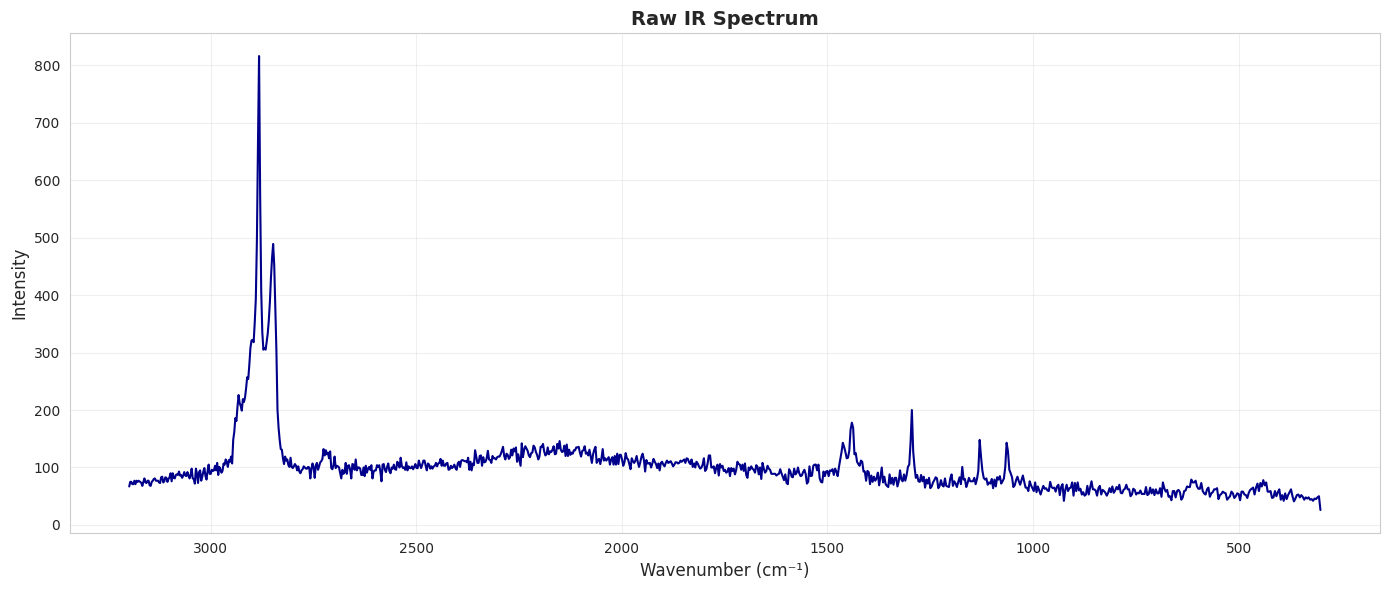

In [54]:
#visualisation of raw spectrum


print("\n[STEP 4] Visualizing Raw Spectrum...")

plt.figure(figsize=(14, 6))
plt.plot(df_clean['wwavenumber'], df_clean['intensity'], linewidth=1.5, color='darkblue')
plt.xlabel('Wavenumber (cm⁻¹)', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.title('Raw IR Spectrum', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # IR spectra are traditionally plotted with decreasing wavenumber
plt.tight_layout()
plt.show()


[STEP 5] Baseline Correction...
✓ Baseline correction applied


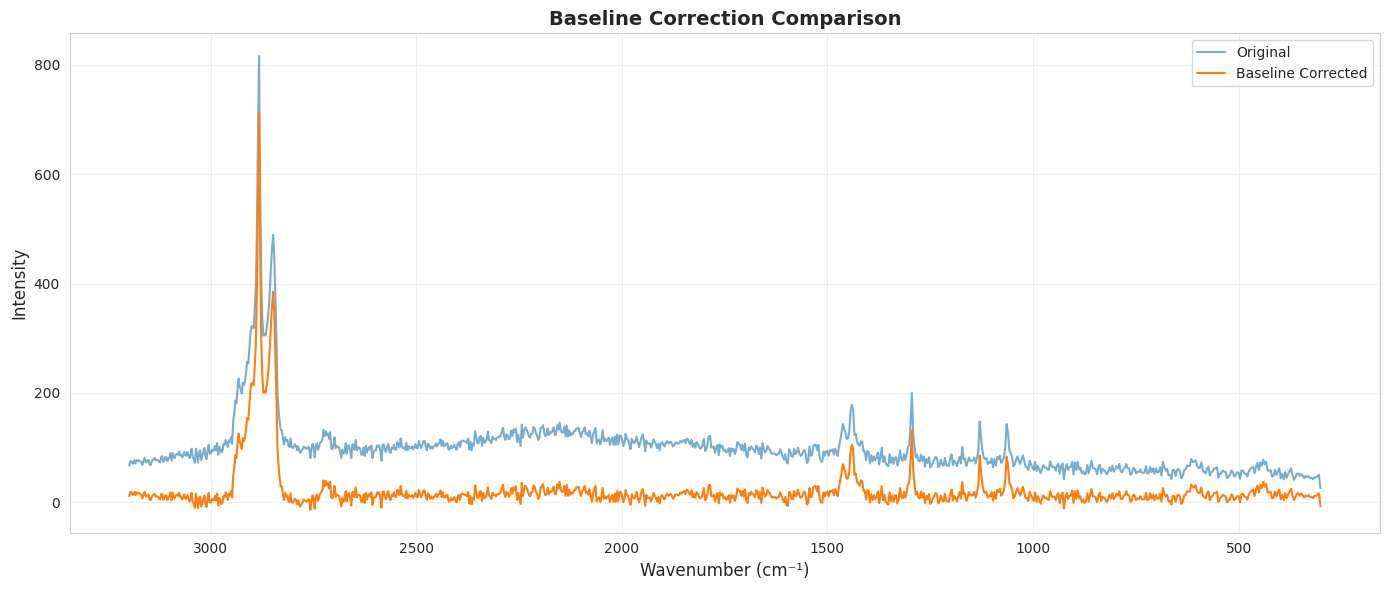

In [55]:
print("\n[STEP 5] Baseline Correction...")

def baseline_correction(spectrum, lam=1e5, p=0.01, niter=10):
    """
    Asymmetric Least Squares baseline correction
    """
    L = len(spectrum)
    # Create second difference matrix (L-2 × L)
    D = np.diff(np.eye(L), n=2, axis=0)
    w = np.ones(L)

    for i in range(niter):
        W = np.diag(w)
        # D.T @ D creates a square L×L matrix
        Z = W + lam * (D.T @ D)
        baseline = np.linalg.solve(Z, w * spectrum)
        w = p * (spectrum > baseline) + (1 - p) * (spectrum < baseline)

    return spectrum - baseline

# Apply baseline correction
intensity_corrected = baseline_correction(df_clean['intensity'].values)
df_clean['intensity_baseline_corrected'] = intensity_corrected

print("✓ Baseline correction applied")

# Visualize before and after
plt.figure(figsize=(14, 6))
plt.plot(df_clean['wwavenumber'], df_clean['intensity'],
         label='Original', alpha=0.6, linewidth=1.5)
plt.plot(df_clean['wwavenumber'], df_clean['intensity_baseline_corrected'],
         label='Baseline Corrected', linewidth=1.5)
plt.xlabel('Wavenumber (cm⁻¹)', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.title('Baseline Correction Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()



[STEP 6] Smoothing with Savitzky-Golay Filter...
✓ Smoothing applied (window=11, order=3)


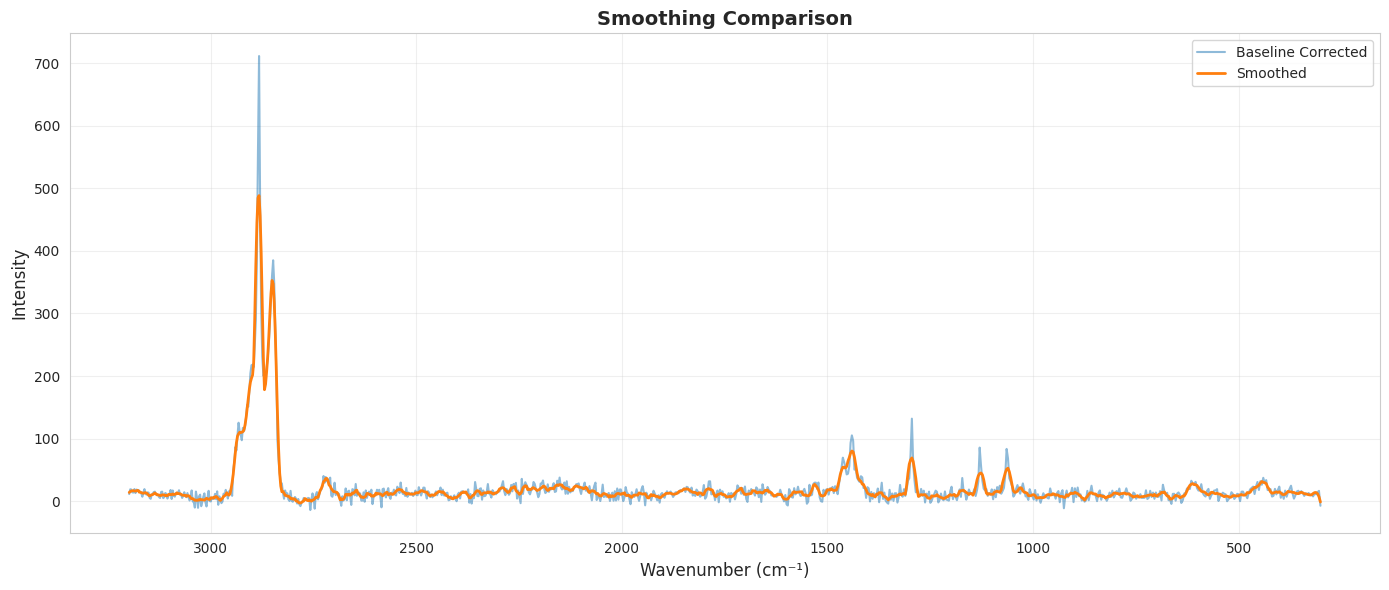

In [56]:
print("\n[STEP 6] Smoothing with Savitzky-Golay Filter...")

# Apply Savitzky-Golay filter for smoothing
window_length = 11  # Must be odd
polyorder = 3

intensity_smoothed = savgol_filter(df_clean['intensity_baseline_corrected'],
                                   window_length, polyorder)
df_clean['intensity_smoothed'] = intensity_smoothed

print(f"✓ Smoothing applied (window={window_length}, order={polyorder})")

# Visualize smoothing
plt.figure(figsize=(14, 6))
plt.plot(df_clean['wwavenumber'], df_clean['intensity_baseline_corrected'],
         label='Baseline Corrected', alpha=0.5, linewidth=1.5)
plt.plot(df_clean['wwavenumber'], df_clean['intensity_smoothed'],
         label='Smoothed', linewidth=2)
plt.xlabel('Wavenumber (cm⁻¹)', fontsize=12)
plt.ylabel('Intensity', fontsize=12)
plt.title('Smoothing Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

In [57]:
#Normalization
print("\n[STEP 7] Normalization...")

# Method 1: Min-Max Normalization (0-1 range)
scaler_minmax = MinMaxScaler()
intensity_minmax = scaler_minmax.fit_transform(
    df_clean['intensity_smoothed'].values.reshape(-1, 1)
).flatten()
df_clean['intensity_minmax'] = intensity_minmax

# Method 2: Standard Normalization (z-score)
scaler_standard = StandardScaler()
intensity_standard = scaler_standard.fit_transform(
    df_clean['intensity_smoothed'].values.reshape(-1, 1)
).flatten()
df_clean['intensity_standard'] = intensity_standard

# Method 3: Vector Normalization (L2 norm)
intensity_vector = df_clean['intensity_smoothed'].values
intensity_vector_norm = intensity_vector / np.linalg.norm(intensity_vector)
df_clean['intensity_vector_norm'] = intensity_vector_norm

print("✓ Three normalization methods applied:")
print("  - Min-Max (0-1 range)")
print("  - Standard (z-score)")
print("  - Vector (L2 norm)")




[STEP 7] Normalization...
✓ Three normalization methods applied:
  - Min-Max (0-1 range)
  - Standard (z-score)
  - Vector (L2 norm)


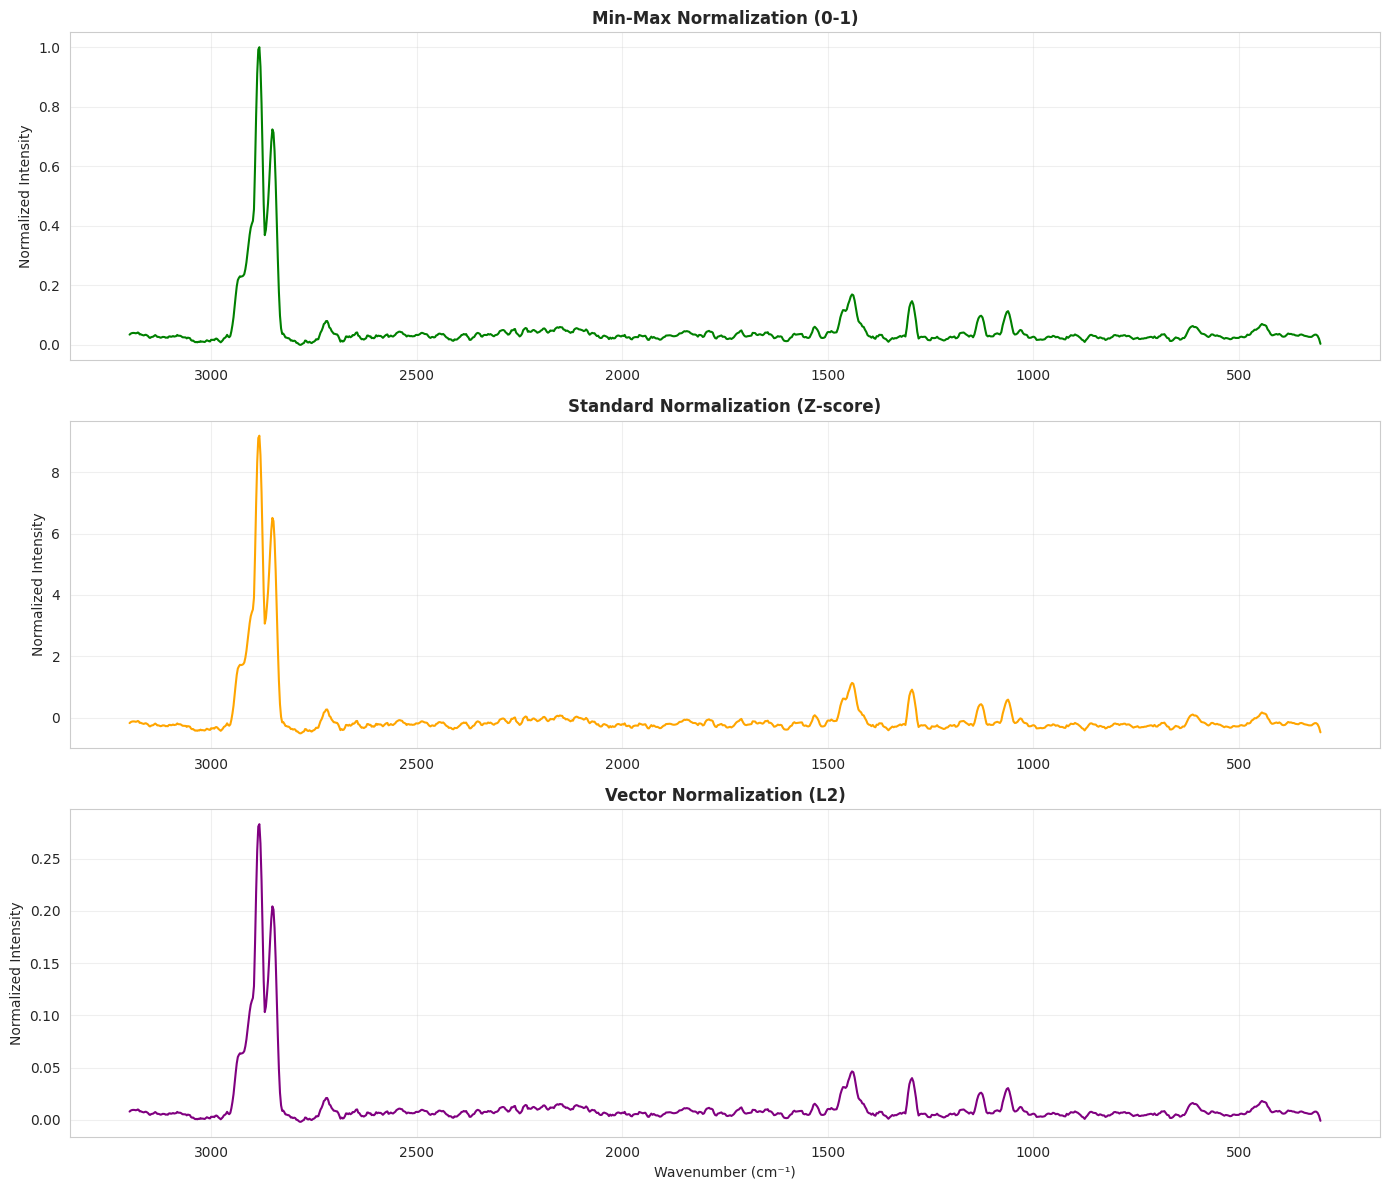

In [58]:


# Visualize normalization methods
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(df_clean['wwavenumber'], df_clean['intensity_minmax'],
             linewidth=1.5, color='green')
axes[0].set_title('Min-Max Normalization (0-1)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Normalized Intensity')
axes[0].grid(True, alpha=0.3)
axes[0].invert_xaxis()

axes[1].plot(df_clean['wwavenumber'], df_clean['intensity_standard'],
             linewidth=1.5, color='orange')
axes[1].set_title('Standard Normalization (Z-score)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Normalized Intensity')
axes[1].grid(True, alpha=0.3)
axes[1].invert_xaxis()

axes[2].plot(df_clean['wwavenumber'], df_clean['intensity_vector_norm'],
             linewidth=1.5, color='purple')
axes[2].set_title('Vector Normalization (L2)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Wavenumber (cm⁻¹)')
axes[2].set_ylabel('Normalized Intensity')
axes[2].grid(True, alpha=0.3)
axes[2].invert_xaxis()

plt.tight_layout()
plt.show()


[STEP 8] Spectral Resampling...
✓ Resampled to 500 uniform points
  Original points: 964
  Resampled points: 500


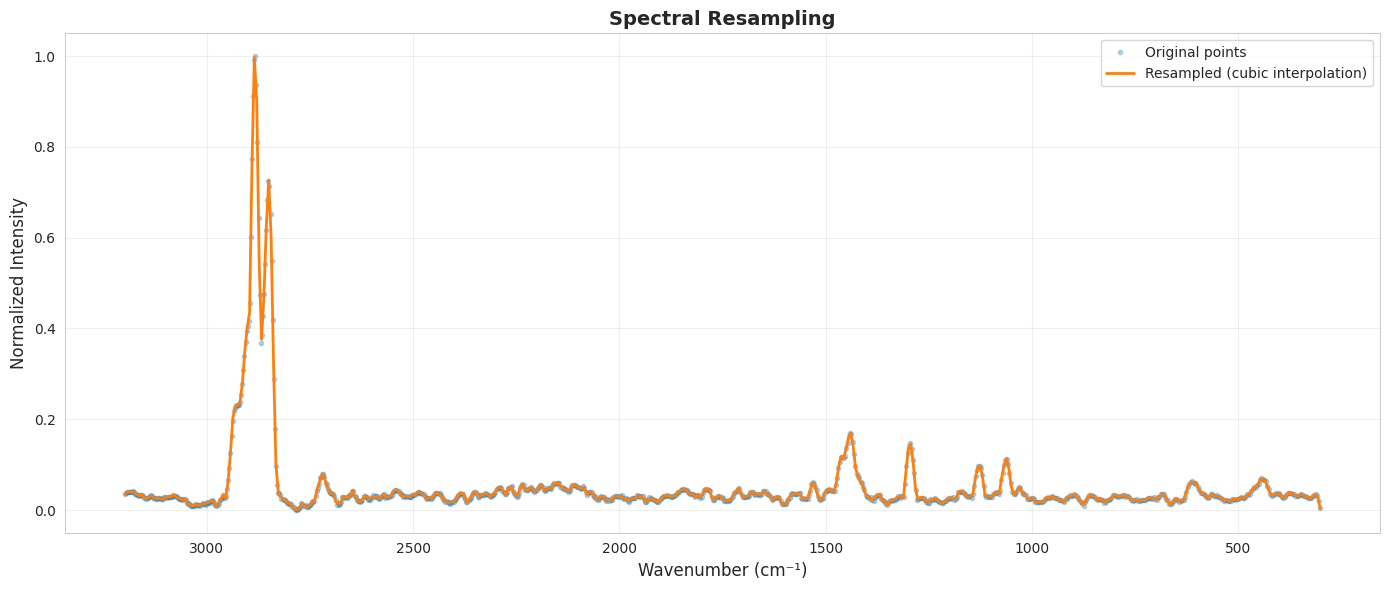

In [59]:
# STEP 8: SPECTRAL RESAMPLING (OPTIONAL)


print("\n[STEP 8] Spectral Resampling...")

# Create uniform wavenumber grid
wavenumber_min = df_clean['wwavenumber'].min()
wavenumber_max = df_clean['wwavenumber'].max()
n_points = 500  # You can adjust this

wavenumber_uniform = np.linspace(wavenumber_min, wavenumber_max, n_points)

# Interpolate intensity values
interpolator = interp1d(df_clean['wwavenumber'],
                       df_clean['intensity_minmax'],
                       kind='cubic')
intensity_resampled = interpolator(wavenumber_uniform)

print(f"✓ Resampled to {n_points} uniform points")
print(f"  Original points: {len(df_clean)}")
print(f"  Resampled points: {len(wavenumber_uniform)}")

# Create resampled dataframe
df_resampled = pd.DataFrame({
    'wwavenumber': wavenumber_uniform,
    'intensity': intensity_resampled
})

# Visualize resampling
plt.figure(figsize=(14, 6))
plt.plot(df_clean['wwavenumber'], df_clean['intensity_minmax'],
         'o', alpha=0.3, label='Original points', markersize=3)
plt.plot(df_resampled['wwavenumber'], df_resampled['intensity'],
         '-', linewidth=2, label='Resampled (cubic interpolation)')
plt.xlabel('Wavenumber (cm⁻¹)', fontsize=12)
plt.ylabel('Normalized Intensity', fontsize=12)
plt.title('Spectral Resampling', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()



In [60]:
print("\n[STEP 9] Feature Extraction - Key IR Regions...")

# Define 31 functional group regions (cm⁻¹) for comprehensive classification
regions = {
    # 1-5: Hydroxyl and Amine stretches (3000-4000 cm⁻¹)
    '1_O-H_alcohol_free': (3550, 3650),           # Free O-H stretch
    '2_O-H_alcohol_bonded': (3200, 3550),         # H-bonded O-H stretch
    '3_N-H_primary_amine': (3300, 3500),          # Primary amine N-H stretch
    '4_N-H_secondary_amine': (3250, 3350),        # Secondary amine N-H stretch
    '5_O-H_carboxylic_acid': (2500, 3300),        # Carboxylic acid O-H (broad)

    # 6-10: C-H stretches (2700-3100 cm⁻¹)
    '6_C-H_alkyne': (3260, 3330),                 # Terminal alkyne C-H
    '7_C-H_aromatic': (3000, 3100),               # Aromatic C-H stretch
    '8_C-H_alkene': (3010, 3095),                 # Alkene =C-H stretch
    '9_C-H_alkane': (2850, 2970),                 # Alkane C-H stretch
    '10_C-H_aldehyde': (2720, 2820),              # Aldehyde C-H stretch

    # 11-13: Triple bonds (2000-2300 cm⁻¹)
    '11_C≡N_nitrile': (2210, 2260),               # Nitrile C≡N stretch
    '12_C≡C_alkyne': (2100, 2260),                # Alkyne C≡C stretch
    '13_N=C=O_isocyanate': (2240, 2280),          # Isocyanate stretch

    # 14-20: Carbonyl groups (1650-1850 cm⁻¹)
    '14_C=O_acid_chloride': (1770, 1815),         # Acid chloride C=O
    '15_C=O_anhydride': (1740, 1850),             # Anhydride C=O (two peaks)
    '16_C=O_ester': (1735, 1750),                 # Ester C=O stretch
    '17_C=O_aldehyde': (1720, 1740),              # Aldehyde C=O stretch
    '18_C=O_ketone': (1705, 1725),                # Ketone C=O stretch
    '19_C=O_carboxylic_acid': (1700, 1725),       # Carboxylic acid C=O
    '20_C=O_amide': (1630, 1690),                 # Amide C=O (Amide I)

    # 21-25: C=C, C=N, and N-H bends (1500-1700 cm⁻¹)
    '21_C=C_aromatic': (1585, 1605),              # Aromatic C=C stretch
    '22_C=C_alkene': (1620, 1680),                # Alkene C=C stretch
    '23_C=N_imine': (1640, 1690),                 # Imine C=N stretch
    '24_N-H_amide_bend': (1550, 1650),            # Amide II (N-H bend)
    '25_NH2_primary_amine_bend': (1580, 1650),    # Primary amine scissoring

    # 26-31: Single bonds and fingerprint (600-1500 cm⁻¹)
    '26_C-O_ester': (1150, 1300),                 # Ester C-O stretch
    '27_C-O_alcohol': (1050, 1150),               # Alcohol C-O stretch
    '28_C-O_ether': (1070, 1150),                 # Ether C-O stretch
    '29_C-N_amine': (1020, 1250),                 # Amine C-N stretch
    '30_S=O_sulfone': (1300, 1350),               # Sulfone S=O stretch
    '31_C-X_halide': (500, 800)                   # C-Cl, C-Br, C-I stretch
}

# Extract features for each region
features = {}

for region_name, (wn_min, wn_max) in regions.items():
    # Filter data in this region
    mask = (df_clean['wwavenumber'] >= wn_min) & (df_clean['wwavenumber'] <= wn_max)
    region_data = df_clean[mask]['intensity_minmax']

    if len(region_data) > 0:
        features[f'{region_name}_max'] = region_data.max()
        features[f'{region_name}_mean'] = region_data.mean()
        features[f'{region_name}_std'] = region_data.std()
        features[f'{region_name}_area'] = np.trapz(region_data)

# Display extracted features
print("\nExtracted Features:")
features_df = pd.DataFrame([features])
print(features_df.T)


[STEP 9] Feature Extraction - Key IR Regions...

Extracted Features:
                                    0
5_O-H_carboxylic_acid_max    1.000000
5_O-H_carboxylic_acid_mean   0.096637
5_O-H_carboxylic_acid_std    0.186736
5_O-H_carboxylic_acid_area  25.575009
7_C-H_aromatic_max           0.033340
...                               ...
30_S=O_sulfone_area          0.530476
31_C-X_halide_max            0.063269
31_C-X_halide_mean           0.029293
31_C-X_halide_std            0.010897
31_C-X_halide_area           2.491924

[104 rows x 1 columns]


In [61]:
print("\n[STEP 10] Saving Preprocessed Data...")

# Save cleaned and processed spectrum
df_clean.to_csv('preprocessed_spectrum.csv', index=False)
print("✓ Full processed spectrum saved: 'preprocessed_spectrum.csv'")

# Save resampled spectrum
df_resampled.to_csv('resampled_spectrum.csv', index=False)
print("✓ Resampled spectrum saved: 'resampled_spectrum.csv'")

# Save extracted features
features_df.to_csv('extracted_features.csv', index=False)
print("✓ Extracted features saved: 'extracted_features.csv'")


[STEP 10] Saving Preprocessed Data...
✓ Full processed spectrum saved: 'preprocessed_spectrum.csv'
✓ Resampled spectrum saved: 'resampled_spectrum.csv'
✓ Extracted features saved: 'extracted_features.csv'


In [62]:
print("PREPROCESSING SUMMARY")
print("="*60)
print(f"✓ Data loaded: {df.shape[0]} data points")
print(f"✓ Data cleaned: {df_clean.shape[0]} data points remaining")
print(f"✓ Baseline correction applied")
print(f"✓ Smoothing applied (Savitzky-Golay)")
print(f"✓ Normalization applied (3 methods)")
print(f"✓ Spectral resampling to {n_points} points")
print(f"✓ Feature extraction from {len(regions)} spectral regions")
print(f"✓ Total features extracted: {len(features)}")

PREPROCESSING SUMMARY
✓ Data loaded: 964 data points
✓ Data cleaned: 964 data points remaining
✓ Baseline correction applied
✓ Smoothing applied (Savitzky-Golay)
✓ Normalization applied (3 methods)
✓ Spectral resampling to 500 points
✓ Feature extraction from 31 spectral regions
✓ Total features extracted: 104


IR SPECTROSCOPY - 31 FUNCTIONAL GROUPS CLASSIFICATION
COMPLETE PIPELINE: DATA GENERATION → TRAINING → EVALUATION

[STEP 1] Generating Synthetic IR Dataset...
--------------------------------------------------------------------------------
Generating synthetic spectra...
  Generated 100/600 spectra...
  Generated 200/600 spectra...
  Generated 300/600 spectra...
  Generated 400/600 spectra...
  Generated 500/600 spectra...
  Generated 600/600 spectra...

✓ Generated 600 synthetic IR spectra

[STEP 2] Building Feature Matrix and Labels...
--------------------------------------------------------------------------------
✓ Feature matrix: (600, 124)
  - 600 samples
  - 124 features

✓ Label matrix: (600, 31)
  - 600 samples
  - 31 functional groups

Top 10 Most Common Functional Groups:
CO_acid_chloride       76
CO_alcohol             69
CO_ester_stretch       68
CC_alkyne              67
CO_amide               67
N-H_secondary_amine    66
O-H_alcohol_bonded     66
CO_ester               65

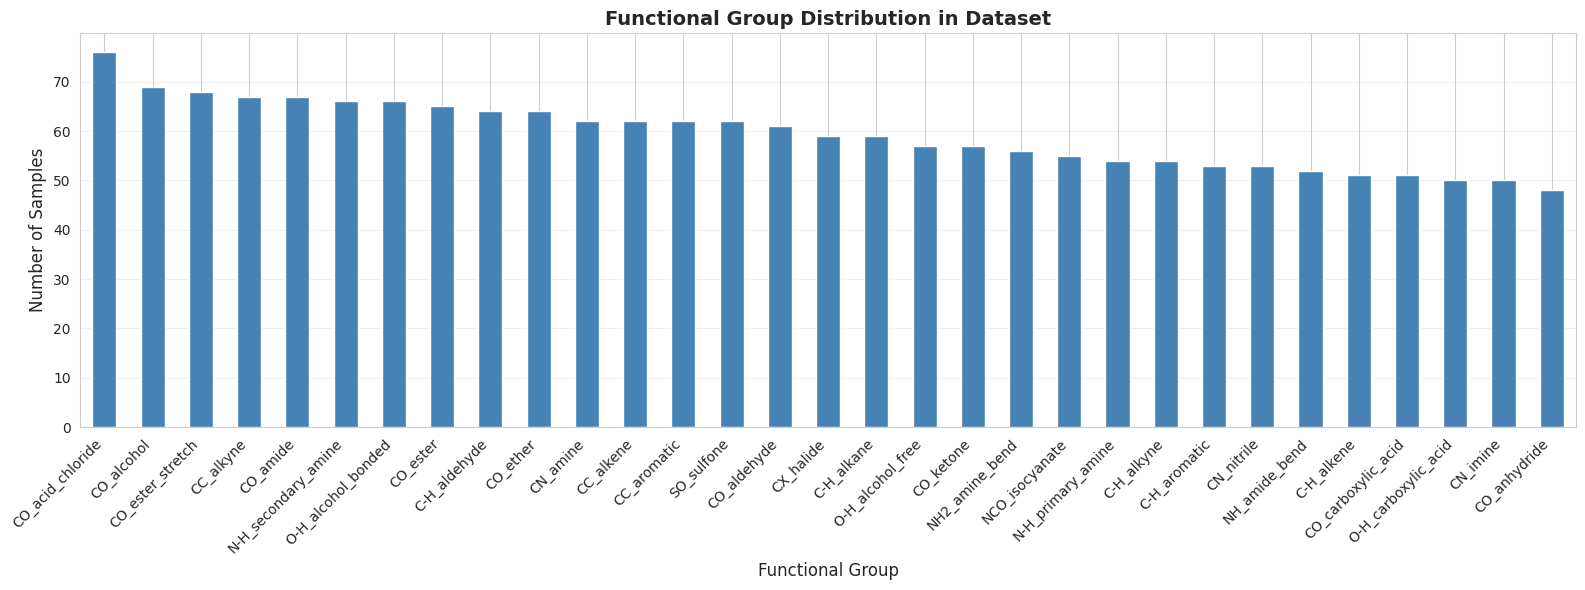


[STEP 3] Preparing Data for Training...
--------------------------------------------------------------------------------
✓ Training set: 480 samples
✓ Test set: 120 samples
✓ Features scaled (standardized)

[STEP 4] Training Individual ML Models...

Training Logistic Regression...
  ✓ Accuracy: 0.1333
  ✓ F1-Micro: 0.5714
  ✓ F1-Macro: 0.5462

Training Random Forest...
  ✓ Accuracy: 0.0917
  ✓ F1-Micro: 0.4904
  ✓ F1-Macro: 0.4295

Training Gradient Boosting...
  ✓ Accuracy: 0.1167
  ✓ F1-Micro: 0.5352
  ✓ F1-Macro: 0.4930

Training K-Nearest Neighbors...
  ✓ Accuracy: 0.0500
  ✓ F1-Micro: 0.3558
  ✓ F1-Macro: 0.3158

Training Decision Tree...
  ✓ Accuracy: 0.1000
  ✓ F1-Micro: 0.5302
  ✓ F1-Macro: 0.5271

Training Neural Network...
  ✓ Accuracy: 0.0583
  ✓ F1-Micro: 0.3272
  ✓ F1-Macro: 0.2739

[STEP 5] Training Ensemble Models...

Training Voting Ensemble (Soft Voting)...
  ✓ Accuracy: 0.1083
  ✓ F1-Micro: 0.5362

Training AdaBoost Ensemble...
  ✓ Accuracy: 0.1250
  ✓ F1-Micro: 0.55

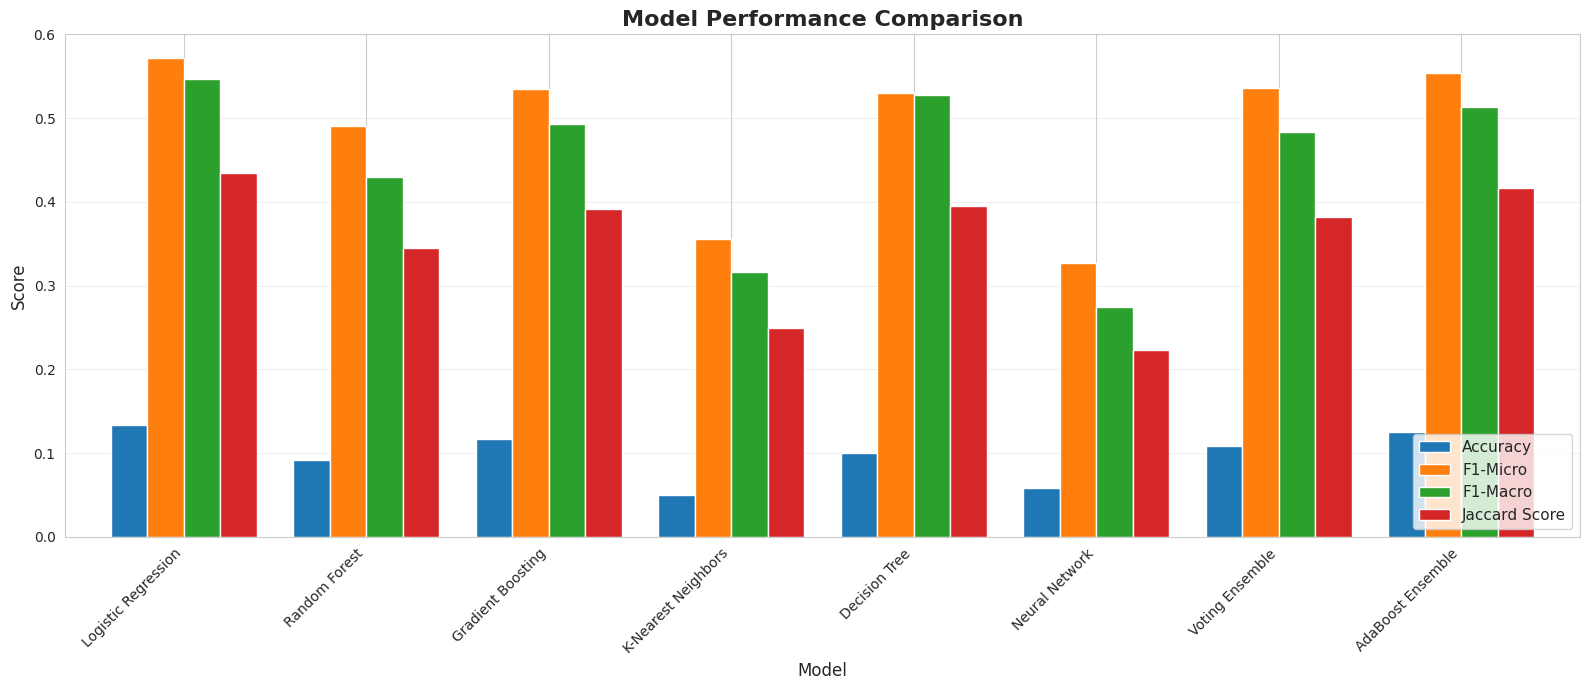


[STEP 7] Detailed Evaluation of Best Model...

Per-Functional Group Performance:
                     precision    recall  f1-score  support
O-H_alcohol_free      1.000000  1.000000  1.000000      9.0
O-H_alcohol_bonded    0.444444  0.666667  0.533333      6.0
N-H_primary_amine     1.000000  0.333333  0.500000      9.0
N-H_secondary_amine   0.666667  0.833333  0.740741     12.0
O-H_carboxylic_acid   0.363636  0.444444  0.400000      9.0
C-H_alkyne            0.400000  0.444444  0.421053      9.0
C-H_aromatic          0.750000  0.272727  0.400000     11.0
C-H_alkene            0.333333  0.500000  0.400000      6.0
C-H_alkane            0.625000  0.454545  0.526316     11.0
C-H_aldehyde          1.000000  0.857143  0.923077      7.0
CN_nitrile            0.636364  0.777778  0.700000      9.0
CC_alkyne             1.000000  1.000000  1.000000     15.0
NCO_isocyanate        0.692308  0.692308  0.692308     13.0
CO_acid_chloride      0.411765  0.777778  0.538462      9.0
CO_anhydride      

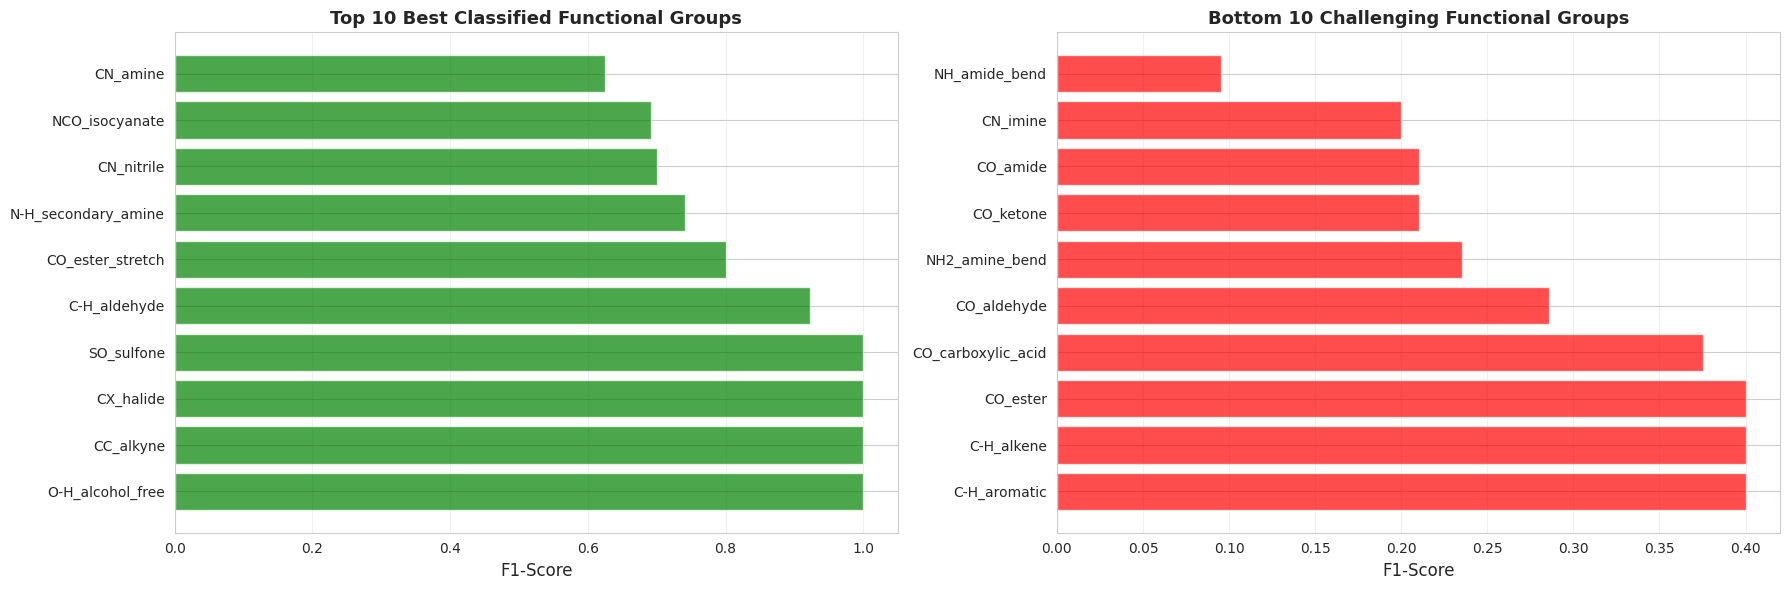


[STEP 8] Saving Results...
--------------------------------------------------------------------------------
✓ Saved: model_comparison.csv
✓ Saved: 'functional_group_performance.csv'
✓ Saved: 'predictions.csv'

PIPELINE COMPLETE!

✓ Dataset: 600 synthetic IR spectra generated
✓ Features: 124 per sample
✓ Functional Groups: 31
✓ Models Trained: 8
✓ Best Model: Logistic Regression
✓ Best F1-Micro Score: 0.5714

Top 3 Models:
  1. Logistic Regression: 0.5714
  2. AdaBoost Ensemble: 0.5541
  3. Voting Ensemble: 0.5362


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, f1_score, hamming_loss,
                            jaccard_score, classification_report)
from sklearn.multioutput import MultiOutputClassifier

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("IR SPECTROSCOPY - 31 FUNCTIONAL GROUPS CLASSIFICATION")
print("COMPLETE PIPELINE: DATA GENERATION → TRAINING → EVALUATION")
print("="*80)

# ============================================================================
# STEP 1: GENERATE SYNTHETIC IR DATASET
# ============================================================================
print("\n[STEP 1] Generating Synthetic IR Dataset...")
print("-" * 80)

# Define 31 functional groups
FUNCTIONAL_GROUPS = [
    'O-H_alcohol_free', 'O-H_alcohol_bonded', 'N-H_primary_amine',
    'N-H_secondary_amine', 'O-H_carboxylic_acid', 'C-H_alkyne',
    'C-H_aromatic', 'C-H_alkene', 'C-H_alkane', 'C-H_aldehyde',
    'CN_nitrile', 'CC_alkyne', 'NCO_isocyanate',
    'CO_acid_chloride', 'CO_anhydride', 'CO_ester',
    'CO_aldehyde', 'CO_ketone', 'CO_carboxylic_acid',
    'CO_amide', 'CC_aromatic', 'CC_alkene', 'CN_imine',
    'NH_amide_bend', 'NH2_amine_bend', 'CO_ester_stretch',
    'CO_alcohol', 'CO_ether', 'CN_amine', 'SO_sulfone',
    'CX_halide'
]

# Wavenumber regions for each group (simplified for synthetic data)
GROUP_REGIONS = {
    'O-H_alcohol_free': 3600, 'O-H_alcohol_bonded': 3400,
    'N-H_primary_amine': 3400, 'N-H_secondary_amine': 3300,
    'O-H_carboxylic_acid': 2900, 'C-H_alkyne': 3300,
    'C-H_aromatic': 3050, 'C-H_alkene': 3050,
    'C-H_alkane': 2900, 'C-H_aldehyde': 2750,
    'CN_nitrile': 2230, 'CC_alkyne': 2150,
    'NCO_isocyanate': 2260, 'CO_acid_chloride': 1790,
    'CO_anhydride': 1800, 'CO_ester': 1740,
    'CO_aldehyde': 1730, 'CO_ketone': 1715,
    'CO_carboxylic_acid': 1710, 'CO_amide': 1660,
    'CC_aromatic': 1595, 'CC_alkene': 1650,
    'CN_imine': 1665, 'NH_amide_bend': 1600,
    'NH2_amine_bend': 1615, 'CO_ester_stretch': 1200,
    'CO_alcohol': 1100, 'CO_ether': 1100,
    'CN_amine': 1150, 'SO_sulfone': 1325,
    'CX_halide': 650
}

def generate_synthetic_spectrum(present_groups, n_points=500):
    """Generate a synthetic IR spectrum with specified functional groups"""
    wavenumbers = np.linspace(400, 4000, n_points)
    spectrum = np.random.normal(0.05, 0.02, n_points)  # Baseline noise

    for group in present_groups:
        center = GROUP_REGIONS[group]
        # Add Gaussian peak
        width = np.random.uniform(30, 100)
        height = np.random.uniform(0.6, 1.0)
        peak = height * np.exp(-((wavenumbers - center) ** 2) / (2 * width ** 2))
        spectrum += peak

    # Normalize
    spectrum = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())
    return spectrum

def extract_features_simple(spectrum):
    """Extract statistical features from spectrum regions"""
    features = []
    n_regions = 31
    region_size = len(spectrum) // n_regions

    for i in range(n_regions):
        start = i * region_size
        end = (i + 1) * region_size if i < n_regions - 1 else len(spectrum)
        region = spectrum[start:end]

        # Extract 4 features per region: max, mean, std, sum
        features.extend([
            np.max(region),
            np.mean(region),
            np.std(region),
            np.sum(region)
        ])

    return features

# Generate dataset
print("Generating synthetic spectra...")
np.random.seed(42)
n_samples = 600

X_data = []
y_data = []

for i in range(n_samples):
    # Each sample has 1-5 functional groups
    n_groups = np.random.randint(1, 6)
    present_groups = np.random.choice(FUNCTIONAL_GROUPS, n_groups, replace=False).tolist()

    # Generate spectrum
    spectrum = generate_synthetic_spectrum(present_groups)

    # Extract features
    features = extract_features_simple(spectrum)

    X_data.append(features)
    y_data.append(present_groups)

    if (i + 1) % 100 == 0:
        print(f"  Generated {i + 1}/{n_samples} spectra...")

print(f"\n✓ Generated {n_samples} synthetic IR spectra")

# ============================================================================
# STEP 2: BUILD FEATURE AND LABEL MATRICES
# ============================================================================
print("\n[STEP 2] Building Feature Matrix and Labels...")
print("-" * 80)

# Create feature matrix
X_features = pd.DataFrame(X_data)
print(f"✓ Feature matrix: {X_features.shape}")
print(f"  - {X_features.shape[0]} samples")
print(f"  - {X_features.shape[1]} features")

# Create label matrix (multi-label binary)
mlb = MultiLabelBinarizer(classes=FUNCTIONAL_GROUPS)
y_matrix = mlb.fit_transform(y_data)
y_df = pd.DataFrame(y_matrix, columns=FUNCTIONAL_GROUPS)

print(f"\n✓ Label matrix: {y_df.shape}")
print(f"  - {y_df.shape[0]} samples")
print(f"  - {y_df.shape[1]} functional groups")

# Show distribution
print("\nTop 10 Most Common Functional Groups:")
print(y_df.sum().sort_values(ascending=False).head(10))

# Visualize distribution
fig, ax = plt.subplots(figsize=(16, 6))
y_df.sum().sort_values(ascending=False).plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Functional Group Distribution in Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Functional Group', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 3: TRAIN-TEST SPLIT AND SCALING
# ============================================================================
print("\n[STEP 3] Preparing Data for Training...")
print("-" * 80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_df, test_size=0.2, random_state=42
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled (standardized)")

# ============================================================================
# STEP 4: TRAIN INDIVIDUAL MODELS
# ============================================================================
print("\n[STEP 4] Training Individual ML Models...")
print("="*80)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10,
                                           random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=5,
                                                    random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300,
                                   random_state=42, early_stopping=True)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Wrap for multi-label
    clf = MultiOutputClassifier(model, n_jobs=-1)

    # Train
    clf.fit(X_train_scaled, y_train)

    # Predict
    y_pred = clf.predict(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    hamming = hamming_loss(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred, average='samples', zero_division=0)

    results[name] = {
        'model': clf,
        'predictions': y_pred,
        'Accuracy': acc,
        'F1-Micro': f1_micro,
        'F1-Macro': f1_macro,
        'Hamming Loss': hamming,
        'Jaccard Score': jaccard
    }

    print(f"  ✓ Accuracy: {acc:.4f}")
    print(f"  ✓ F1-Micro: {f1_micro:.4f}")
    print(f"  ✓ F1-Macro: {f1_macro:.4f}")

# ============================================================================
# STEP 5: TRAIN ENSEMBLE MODELS
# ============================================================================
print("\n[STEP 5] Training Ensemble Models...")
print("="*80)

# Ensemble 1: Voting Classifier
print("\nTraining Voting Ensemble (Soft Voting)...")
voting_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42))
]

voting_clf = MultiOutputClassifier(
    VotingClassifier(estimators=voting_estimators, voting='soft', n_jobs=-1)
)
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)

results['Voting Ensemble'] = {
    'model': voting_clf,
    'predictions': y_pred_voting,
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'F1-Micro': f1_score(y_test, y_pred_voting, average='micro', zero_division=0),
    'F1-Macro': f1_score(y_test, y_pred_voting, average='macro', zero_division=0),
    'Hamming Loss': hamming_loss(y_test, y_pred_voting),
    'Jaccard Score': jaccard_score(y_test, y_pred_voting, average='samples', zero_division=0)
}

print(f"  ✓ Accuracy: {results['Voting Ensemble']['Accuracy']:.4f}")
print(f"  ✓ F1-Micro: {results['Voting Ensemble']['F1-Micro']:.4f}")

# Ensemble 2: AdaBoost
print("\nTraining AdaBoost Ensemble...")
adaboost_clf = MultiOutputClassifier(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                      n_estimators=50, random_state=42)
)
adaboost_clf.fit(X_train_scaled, y_train)
y_pred_adaboost = adaboost_clf.predict(X_test_scaled)

results['AdaBoost Ensemble'] = {
    'model': adaboost_clf,
    'predictions': y_pred_adaboost,
    'Accuracy': accuracy_score(y_test, y_pred_adaboost),
    'F1-Micro': f1_score(y_test, y_pred_adaboost, average='micro', zero_division=0),
    'F1-Macro': f1_score(y_test, y_pred_adaboost, average='macro', zero_division=0),
    'Hamming Loss': hamming_loss(y_test, y_pred_adaboost),
    'Jaccard Score': jaccard_score(y_test, y_pred_adaboost, average='samples', zero_division=0)
}

print(f"  ✓ Accuracy: {results['AdaBoost Ensemble']['Accuracy']:.4f}")
print(f"  ✓ F1-Micro: {results['AdaBoost Ensemble']['F1-Micro']:.4f}")

# ============================================================================
# STEP 6: COMPARE ALL MODELS
# ============================================================================
print("\n[STEP 6] Model Comparison...")
print("="*80)

# Create comparison dataframe
comparison_data = {
    name: {k: v for k, v in info.items() if k not in ['model', 'predictions']}
    for name, info in results.items()
}

comparison_df = pd.DataFrame(comparison_data).T
print("\n" + comparison_df.to_string())

# Find best model
best_model_name = comparison_df['F1-Micro'].idxmax()
print(f"\n✓ BEST MODEL: {best_model_name}")
print(f"  F1-Micro: {comparison_df.loc[best_model_name, 'F1-Micro']:.4f}")
print(f"  Accuracy: {comparison_df.loc[best_model_name, 'Accuracy']:.4f}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(16, 7))
comparison_df[['Accuracy', 'F1-Micro', 'F1-Macro', 'Jaccard Score']].plot(
    kind='bar', ax=ax, width=0.8
)
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 7: DETAILED EVALUATION OF BEST MODEL
# ============================================================================
print("\n[STEP 7] Detailed Evaluation of Best Model...")
print("="*80)

best_predictions = results[best_model_name]['predictions']

# Per-class report
print("\nPer-Functional Group Performance:")
report = classification_report(y_test, best_predictions,
                              target_names=FUNCTIONAL_GROUPS,
                              zero_division=0, output_dict=True)

report_df = pd.DataFrame(report).T
print(report_df.iloc[:-3][['precision', 'recall', 'f1-score', 'support']].head(15))

# Top and bottom performers
fg_f1_scores = report_df.iloc[:-3]['f1-score'].sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 10
axes[0].barh(fg_f1_scores.head(10).index, fg_f1_scores.head(10).values,
            color='green', alpha=0.7)
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_title('Top 10 Best Classified Functional Groups', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Bottom 10
axes[1].barh(fg_f1_scores.tail(10).index, fg_f1_scores.tail(10).values,
            color='red', alpha=0.7)
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('Bottom 10 Challenging Functional Groups', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 8: SAVE RESULTS
# ============================================================================
print("\n[STEP 8] Saving Results...")
print("-" * 80)

# Save comparison
comparison_df.to_csv('model_comparison.csv')
print("✓ Saved: model_comparison.csv")

# Save per-group performance
report_df.to_csv('functional_group_performance.csv')
print("✓ Saved: 'functional_group_performance.csv'")

# Save predictions
pred_df = pd.DataFrame(best_predictions, columns=FUNCTIONAL_GROUPS)
pred_df.to_csv('predictions.csv', index=False)
print("✓ Saved: 'predictions.csv'")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\n✓ Dataset: {n_samples} synthetic IR spectra generated")
print(f"✓ Features: {X_features.shape[1]} per sample")
print(f"✓ Functional Groups: {len(FUNCTIONAL_GROUPS)}")
print(f"✓ Models Trained: {len(results)}")
print(f"✓ Best Model: {best_model_name}")
print(f"✓ Best F1-Micro Score: {comparison_df.loc[best_model_name, 'F1-Micro']:.4f}")
print("\nTop 3 Models:")
for i, (name, row) in enumerate(comparison_df.nlargest(3, 'F1-Micro').iterrows(), 1):
    print(f"  {i}. {name}: {row['F1-Micro']:.4f}")
print("="*80)